# Linear Regression Model Training
### Read in features and labels
### Do some multivariate linear regression
### See how good the fits are
### Make some plots of the final WhereSIOUS scores & print some stats

In [1]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from scipy.stats.stats import pearsonr
from sklearn import cross_validation

%matplotlib inline

In [2]:
# read in features and labels/examples (see build_features_labels2.ipynb for more info)
features = pd.read_csv('data_final/features.csv')
# drop tract 9902 (mostly SD Harbor, not much land) is always best tract, w/ only 3 quite old businesses (10-30 yr)
#features = features[features.census_tract != 9902]
# drop tract 3800 (mostly Naval Base SD) is always worst tract, w/ 11 relatively young businesses (typically ~3 yr)
#features = features[features.census_tract != 3800]
print features.shape
print features.columns
features[-10:]

(314, 50)
Index([u'census_tract', u'bus_age', u'n_business', u'n_businesses_11',
       u'n_businesses_21', u'n_businesses_22', u'n_businesses_23',
       u'n_businesses_31', u'n_businesses_32', u'n_businesses_33',
       u'n_businesses_42', u'n_businesses_44', u'n_businesses_45',
       u'n_businesses_48', u'n_businesses_49', u'n_businesses_51',
       u'n_businesses_52', u'n_businesses_53', u'n_businesses_54',
       u'n_businesses_55', u'n_businesses_56', u'n_businesses_61',
       u'n_businesses_62', u'n_businesses_71', u'n_businesses_72',
       u'n_businesses_81', u'n_businesses_92', u'population',
       u'population_percent_male', u'population_percent_female', u'age_med',
       u'age_med_male', u'age_med_female', u'minor_percent', u'adult_percent',
       u'homes', u'homes_percent_mortgage', u'homes_percent_clear',
       u'homes_percent_rent', u'employment_percent', u'income_med',
       u'income_med_owner', u'income_med_renter', u'cost_med',
       u'cost_med_owner', u'cost_

,census_tract,bus_age,n_business,n_businesses_11,n_businesses_21,n_businesses_22,n_businesses_23,n_businesses_31,n_businesses_32,n_businesses_33,...,income_med,income_med_owner,income_med_renter,cost_med,cost_med_owner,cost_med_renter,walk_score,transit_score,bike_score,total_amount
304,20404,0.527227,0.000000,0.00,0.0,0.000,0.000000,0.000000,0.00,0.000000,...,0.359025,0.373079,0.289875,0.447126,0.60800,0.7210,0.000000,0.00000,0.000000,0.000000
305,20706,0.487126,0.000000,0.00,0.0,0.000,0.005405,0.000000,0.00,0.000000,...,0.614709,0.477346,0.154967,0.741594,0.71475,0.8270,0.000000,0.00000,0.000000,0.000000
306,20707,0.031962,0.000000,0.00,0.0,0.000,0.005405,0.000000,0.00,0.000000,...,0.246607,0.318921,0.212403,0.341920,0.49300,0.6055,0.000000,0.00000,0.000000,0.000000
307,20709,0.012578,0.000000,0.00,0.0,0.000,0.000000,0.000000,0.00,0.000000,...,0.461417,0.357361,0.313001,0.591106,0.56675,0.9195,0.000000,0.00000,0.000000,0.000000
308,20710,0.674460,0.000305,0.00,0.0,0.000,0.000000,0.000000,0.00,0.000000,...,0.630376,0.514817,0.287666,0.655098,0.63675,1.0000,0.000000,0.00000,0.000000,0.000000
309,21100,0.424090,0.000000,0.00,0.0,0.000,0.005405,0.000000,0.00,0.000000,...,0.333175,0.304606,0.126580,0.272505,0.28700,0.4215,0.000000,0.00000,0.000000,0.000000
310,21302,0.243267,0.000000,0.00,0.0,0.000,0.000000,0.000000,0.00,0.000000,...,0.456233,0.398242,0.238156,0.493492,0.54975,0.6685,0.000000,0.00000,0.000000,0.000000
311,21400,0.481725,0.190549,0.75,0.0,0.125,0.108108,0.147059,0.05,0.060811,...,0.362907,0.425573,0.251232,0.498915,0.54725,0.7370,0.597938,0.54321,0.714286,0.000383
312,21500,0.360906,0.083537,0.00,0.0,0.000,0.027027,0.000000,0.05,0.006757,...,1.000000,0.778459,0.279470,1.000000,0.98100,1.0000,0.340206,0.00000,0.559524,0.000000
313,21800,0.205090,0.013415,0.00,0.0,0.000,0.005405,0.000000,0.00,0.000000,...,0.589478,0.539176,0.466283,0.493221,0.38250,1.0000,0.000000,0.00000,0.000000,0.000000


## Fit w/ all input features (using statsmodels)

In [3]:
# fit the data
#   + to use feature
#   - to remove feature
#   : to multiply 2 features
#   * to multiply 2 features *and* use both individually
#   C(<feature>) to make <feature> into dummy/categorical feature
formula_str = 'bus_age ~ n_business + n_businesses_11 + n_businesses_21 + n_businesses_22 ' \
                '+ n_businesses_23 + n_businesses_31 + n_businesses_32 + n_businesses_33 + n_businesses_42 ' \
                '+ n_businesses_44 + n_businesses_45 + n_businesses_48 + n_businesses_49 + n_businesses_51 ' \
                '+ n_businesses_52 + n_businesses_53 + n_businesses_54 + n_businesses_55 + n_businesses_56 ' \
                '+ n_businesses_61 + n_businesses_62 + n_businesses_71 + n_businesses_72 + n_businesses_81 ' \
                '+ n_businesses_92 + population - population_percent_male + population_percent_female + age_med ' \
                '- age_med_male - age_med_female - minor_percent + adult_percent + homes - homes_percent_mortgage '\
                '- homes_percent_clear - homes_percent_rent + employment_percent + income_med + income_med_owner '\
                '+ income_med_renter + cost_med + cost_med_owner + cost_med_renter + walk_score + transit_score '\
                '+ bike_score + total_amount '
#                '+ n_business:population + n_businesses_11:population + n_businesses_21:population + n_businesses_22:population ' \
#                '+ n_businesses_23:population + n_businesses_31:population + n_businesses_32:population + n_businesses_33:population + n_businesses_42:population ' \
#                '+ n_businesses_44:population + n_businesses_45:population + n_businesses_48:population + n_businesses_49:population + n_businesses_51:population ' \
#                '+ n_businesses_52:population + n_businesses_53:population + n_businesses_54:population + n_businesses_55:population + n_businesses_56:population ' \
#                '+ n_businesses_61:population + n_businesses_62:population + n_businesses_71:population + n_businesses_72:population + n_businesses_81:population ' \
#                '+ n_businesses_92:population'
#                '+ n_business:homes + n_businesses_11:homes + n_businesses_21:homes + n_businesses_22:homes ' \
#                '+ n_businesses_23:homes + n_businesses_31:homes + n_businesses_32:homes + n_businesses_33:homes + n_businesses_42:homes ' \
#                '+ n_businesses_44:homes + n_businesses_45:homes + n_businesses_48:homes + n_businesses_49:homes + n_businesses_51:homes ' \
#                '+ n_businesses_52:homes + n_businesses_53:homes + n_businesses_54:homes + n_businesses_55:homes + n_businesses_56:homes ' \
#                '+ n_businesses_61:homes + n_businesses_62:homes + n_businesses_71:homes + n_businesses_72:homes + n_businesses_81:homes ' \
#                '+ n_businesses_92:homes'
#                '+ n_business:income_med + n_businesses_11:income_med + n_businesses_21:income_med + n_businesses_22:income_med ' \
#                '+ n_businesses_23:income_med + n_businesses_31:income_med + n_businesses_32:income_med + n_businesses_33:income_med + n_businesses_42:income_med ' \
#                '+ n_businesses_44:income_med + n_businesses_45:income_med + n_businesses_48:income_med + n_businesses_49:income_med + n_businesses_51:income_med ' \
#                '+ n_businesses_52:income_med + n_businesses_53:income_med + n_businesses_54:income_med + n_businesses_55:income_med + n_businesses_56:income_med ' \
#                '+ n_businesses_61:income_med + n_businesses_62:income_med + n_businesses_71:income_med + n_businesses_72:income_med + n_businesses_81:income_med ' \
#                '+ n_businesses_92:income_med'
#                '+ n_business:cost_med + n_businesses_11:cost_med + n_businesses_21:cost_med + n_businesses_22:cost_med ' \
#                '+ n_businesses_23:cost_med + n_businesses_31:cost_med + n_businesses_32:cost_med + n_businesses_33:cost_med + n_businesses_42:cost_med ' \
#                '+ n_businesses_44:cost_med + n_businesses_45:cost_med + n_businesses_48:cost_med + n_businesses_49:cost_med + n_businesses_51:cost_med ' \
#                '+ n_businesses_52:cost_med + n_businesses_53:cost_med + n_businesses_54:cost_med + n_businesses_55:cost_med + n_businesses_56:cost_med ' \
#                '+ n_businesses_61:cost_med + n_businesses_62:cost_med + n_businesses_71:cost_med + n_businesses_72:cost_med + n_businesses_81:cost_med ' \
#                '+ n_businesses_92:cost_med'
#                '+ n_business:walk_score + n_businesses_11:walk_score + n_businesses_21:walk_score + n_businesses_22:walk_score ' \
#                '+ n_businesses_23:walk_score + n_businesses_31:walk_score + n_businesses_32:walk_score + n_businesses_33:walk_score + n_businesses_42:walk_score ' \
#                '+ n_businesses_44:walk_score + n_businesses_45:walk_score + n_businesses_48:walk_score + n_businesses_49:walk_score + n_businesses_51:walk_score ' \
#                '+ n_businesses_52:walk_score + n_businesses_53:walk_score + n_businesses_54:walk_score + n_businesses_55:walk_score + n_businesses_56:walk_score ' \
#                '+ n_businesses_61:walk_score + n_businesses_62:walk_score + n_businesses_71:walk_score + n_businesses_72:walk_score + n_businesses_81:walk_score ' \
#                '+ n_businesses_92:walk_score'
model = smf.ols(formula=formula_str, data=features).fit()

print len(model.params)
# print the coefficients
model.params

42


Intercept                   -6.692221e+06
n_business                  -2.195048e+10
n_businesses_11              2.676888e+07
n_businesses_21              6.692221e+06
n_businesses_22              5.353777e+07
n_businesses_23              1.238061e+09
n_businesses_31              2.275355e+08
n_businesses_32              2.676888e+08
n_businesses_33              9.904487e+08
n_businesses_42              1.766746e+09
n_businesses_44              1.900591e+09
n_businesses_45              3.359495e+09
n_businesses_48              1.231369e+09
n_businesses_49              4.416866e+08
n_businesses_51              3.881488e+08
n_businesses_52              5.688388e+08
n_businesses_53              1.110909e+09
n_businesses_54              5.795463e+09
n_businesses_55              1.003833e+08
n_businesses_56              9.703720e+08
n_businesses_61              4.550710e+08
n_businesses_62              1.673055e+09
n_businesses_71              5.086088e+08
n_businesses_72              1.639

In [10]:
# print a summary of the model
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                bus_age   R-squared:                       0.228
Model:                            OLS   Adj. R-squared:                  0.111
Method:                 Least Squares   F-statistic:                     1.955
Date:                Thu, 22 Sep 2016   Prob (F-statistic):           0.000913
Time:                        09:48:38   Log-Likelihood:                 222.42
No. Observations:                 314   AIC:                            -360.8
Df Residuals:                     272   BIC:                            -203.4
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                 -6.692e+06   3.04e+07     -0.220      0.826   -6.65e+07    5.31e+07
n_business                -2.195e+10   9.97e+10     -0.220      0.826   -2.18e+11    1.74e+11
n_businesses_11            2.677e+07   1.22e+08      0.220      0.826   -2.13e+08    2.66e+08
n_businesses_21            6.692e+06   3.04e+07      0.220      0.826   -5.31e+07    6.65e+07
n_businesses_22            5.354e+07   2.43e+08      0.220      0.826   -4.25e+08    5.32e+08
n_businesses_23            1.238e+09   5.62e+09      0.220      0.826   -9.83e+09    1.23e+10
n_businesses_31            2.275e+08   1.03e+09      0.220      0.826   -1.81e+09    2.26e+09
n_businesses_32            2.677e+08   1.22e+09      0.220      0.826   -2.13e+09    2.66e+09
n_businesses_33            9.904e+08    4.5e+09      0.220      0.826   -7.86e+09    9.84e+09
n_businesses_42            1.767e+09   8.02e+09      0.220      0.826    -1.4e+10    1.76e+10
n_businesses_44            1.901e+09   8.63e+09      0.220      0.826   -1.51e+10    1.89e+10
n_businesses_45            3.359e+09   1.53e+10      0.220      0.826   -2.67e+10    3.34e+10
n_businesses_48            1.231e+09   5.59e+09      0.220      0.826   -9.78e+09    1.22e+10
n_businesses_49            4.417e+08   2.01e+09      0.220      0.826   -3.51e+09    4.39e+09
n_businesses_51            3.881e+08   1.76e+09      0.220      0.826   -3.08e+09    3.86e+09
n_businesses_52            5.688e+08   2.58e+09      0.220      0.826   -4.52e+09    5.65e+09
n_businesses_53            1.111e+09   5.04e+09      0.220      0.826   -8.82e+09     1.1e+10
n_businesses_54            5.795e+09   2.63e+10      0.220      0.826    -4.6e+10    5.76e+10
n_businesses_55            1.004e+08   4.56e+08      0.220      0.826   -7.97e+08    9.98e+08
n_businesses_56            9.704e+08   4.41e+09      0.220      0.826    -7.7e+09    9.64e+09
n_businesses_61            4.551e+08   2.07e+09      0.220      0.826   -3.61e+09    4.52e+09
n_businesses_62            1.673e+09    7.6e+09      0.220      0.826   -1.33e+10    1.66e+10
n_businesses_71            5.086e+08   2.31e+09      0.220      0.826   -4.04e+09    5.06e+09
n_businesses_72             1.64e+09   7.44e+09      0.220      0.826    -1.3e+10    1.63e+10
n_businesses_81            3.426e+09   1.56e+10      0.220      0.826   -2.72e+10    3.41e+10
n_businesses_92            6.692e+06   3.04e+07      0.220      0.826   -5.31e+07    6.65e+07
population                    0.0582      0.167      0.349      0.728      -0.270       0.386
population_percent_female     0.1722      0.116      1.484      0.139      -0.056       0.401
age_med                       0.2724      0.078      3.489      0.001       0.119       0.426
adult_percent                 0.1598      0.119      1.346      0.180      

## Leave One Out Cross-Validation

In [11]:
# define LOO for looping purposes
loo = cross_validation.LeaveOneOut(len(features))

# initialize resulting RMSE
RMSE_loo = []

# go through each example as the hold-out
for train_index, test_index in loo:
    # train model
    model_loo = smf.ols(formula=formula_str, data=features.loc[train_index]).fit()
    # get result from hold-out
    prediction = model_loo.predict(features.loc[test_index])
    # save current result
    RMSE_loo.append((abs(prediction.values-features.loc[test_index].bus_age.values))[0])

# take mean of all results
RMSE_loo_arr = np.array(RMSE_loo)
print "LOOCV (median): " + str(np.median(RMSE_loo_arr))
loocv = RMSE_loo_arr.mean()
print "LOOCV = " + str(loocv)

LOOCV (median): 0.069853620626
LOOCV = 0.105288612345


## Predict new ages by adding 1 business to every tract/code combo

In [12]:
# read in min/max values for each feature
minmax = pd.read_csv('data_final/min_max_features.csv',index_col=0)
minmax

,bus_age,n_business,n_businesses_11,n_businesses_21,n_businesses_22,n_businesses_23,n_businesses_31,n_businesses_32,n_businesses_33,n_businesses_42,...,income_med,income_med_owner,income_med_renter,cost_med,cost_med_owner,cost_med_renter,walk_score,transit_score,bike_score,total_amount
min_max,,,,,,,,,,,,,,,,,,,,,
max_vals,1.0,3281.0,4.0,1.0,8.0,185.0,34.0,40.0,148.0,264.0,...,172846.0,230179.0,188750.0,3688.0,4000.0,2000.0,97.0,81.0,84.0,191205635.0
min_vals,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
# define list of simple NAICS business codes
codes = [11,21,22,23,31,32,33,42,44,45,48,49,51,52,53,54,55,56,61,62,71,72,81,92]

# initialize lists of tracts, codes, and final predicted ages
tracts_final = np.ndarray(0)
codes_final = np.ndarray(0)
bus_age_pred_final = np.ndarray(0)
bus_age_diff_final = np.ndarray(0)

# go through each code
for code in codes:
    # reset new features dataframe
    new_features = features.copy()
    
    # save min/max of total business count
    temp_min = minmax.loc['min_vals']['n_business']
    temp_max = minmax.loc['max_vals']['n_business']
    # unscale total business count
    temp_n_bus = new_features['n_business'] * (temp_max-temp_min) + temp_min
    # increment total business count
    temp_n_bus += 1
    # rescale and save new total business count
    new_features['n_business'] = (temp_n_bus-temp_min) / (temp_max-temp_min)
    
    # save min/max of current code business count
    temp_min = minmax.loc['min_vals']['n_businesses_'+str(code)]
    temp_max = minmax.loc['max_vals']['n_businesses_'+str(code)]
    # unscale total business count
    temp_n_bus = new_features['n_businesses_'+str(code)] * (temp_max-temp_min) + temp_min
    # increment total business count
    temp_n_bus += 1
    # rescale and save new total business count
    new_features['n_businesses_'+str(code)] = (temp_n_bus-temp_min) / (temp_max-temp_min)

    # make predictions for this code for all tracts
    bus_age_pred = model.predict(new_features)
    # calculate change in age
    bus_age_diff = bus_age_pred - new_features['bus_age']
    
    # update lists of tracts, codes, and final predicted ages
    tracts_final = np.concatenate((tracts_final,new_features.census_tract.values))
    codes_final = np.concatenate((codes_final,[code]*len(bus_age_pred)))
    bus_age_pred_final = np.concatenate((bus_age_pred_final,bus_age_pred))
    bus_age_diff_final = np.concatenate((bus_age_diff_final,bus_age_diff))

In [14]:
# check stuff that will be saved
print tracts_final.shape
#print tracts_final[:400]
print codes_final.shape
#codes_final[:400]
print bus_age_pred_final.shape
#bus_age_pred_final[:400]
print bus_age_diff_final.shape
#bus_age_diff_final[:400]

(7536,)
(7536,)
(7536,)
(7536,)


## Plot ages, model output ages, and model output ages for adding a business to each tract/code combo

(314,)
(314,)
0.420010126391
0.418629512191
0.0646871397159

(7536,)
0.397774429193
0.403774499893
0.0775103922102


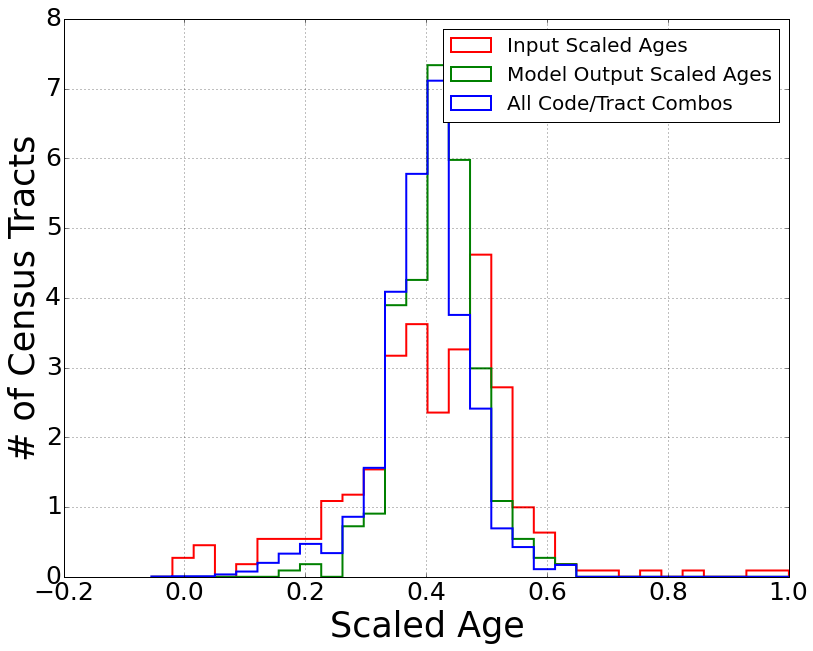

In [15]:
# make histogram of scaled ages input and output and final output (for each business/tract combo)
plt.figure(figsize=(13, 10))
plt.hist([bus_age_pred_final,bus_age_pred,features.bus_age], bins=30, histtype='step', align='mid', linewidth=2, normed=1, \
         label=['All Code/Tract Combos','Model Output Scaled Ages','Input Scaled Ages'])
plt.legend(loc=0,fontsize=20)
plt.grid()
plt.tick_params(axis='both', which='major', labelsize=25)
plt.xlabel('Scaled Age',fontsize=35)
plt.ylabel('# of Census Tracts',fontsize=35)

# print some stats about the model output
print features.bus_age.shape
print bus_age_pred.shape
print np.mean(bus_age_pred)
print np.median(bus_age_pred)
print np.std(bus_age_pred)
print

# print some stats about the model output for each tract/code combo
print bus_age_pred_final.shape
print np.mean(bus_age_pred_final)
print np.median(bus_age_pred_final)
print np.std(bus_age_pred_final)

## Save newly made lists of tract/code combos and scores and diff to dataframes

In [16]:
# scale ages to 0 to 100 to get WhereSIOUS score
print min(bus_age_pred_final)
print max(bus_age_pred_final)
score = 100 * (bus_age_pred_final-min(bus_age_pred_final)) / (max(bus_age_pred_final)-min(bus_age_pred_final))

# save lists of tracts, codes, and final predicted ages as a dataframe
df_ages = pd.DataFrame({'census_tract': tracts_final, 'code_simple': codes_final, \
                        'score': score})
print df_ages.shape
print df_ages[:538]

-0.0550114810467
0.645434950527
(7536, 3)
     census_tract  code_simple      score
0           100.0         11.0  81.400162
1           201.0         11.0  78.323715
2           202.0         11.0  75.933024
3           300.0         11.0  78.252983
4           400.0         11.0  72.439346
5           500.0         11.0  76.669361
6           600.0         11.0  69.085709
7           700.0         11.0  69.875155
8           800.0         11.0  67.594467
9           900.0         11.0  66.235513
10         1000.0         11.0  79.302548
11         1100.0         11.0  77.605613
12         1200.0         11.0  67.556140
13         1300.0         11.0  58.687107
14         1400.0         11.0  64.173860
15         1500.0         11.0  69.086262
16         1600.0         11.0  64.394886
17         1700.0         11.0  69.847414
18         1800.0         11.0  62.567126
19         1900.0         11.0  78.925704
20         2001.0         11.0  84.232335
21         2002.0         11.0  74

In [17]:
# scale diffs to 0 to 100 to get WhereSIOUS Diff score
print min(bus_age_diff_final)
print max(bus_age_diff_final)
score = 100 * (bus_age_diff_final-min(bus_age_diff_final)) / (max(bus_age_diff_final)-min(bus_age_diff_final))

# save lists of tracts, codes, and final predicted ages as a dataframe
df_diffs = pd.DataFrame({'census_tract': tracts_final, 'code_simple': codes_final, \
                          'score': score})
print df_diffs.shape
print df_diffs[:538]

-0.771549370978
0.410169248506
(7536, 3)
     census_tract  code_simple      score
0           100.0         11.0  63.029059
1           201.0         11.0  61.512325
2           202.0         11.0  59.788493
3           300.0         11.0  65.884344
4           400.0         11.0  59.865160
5           500.0         11.0  68.082393
6           600.0         11.0  68.790114
7           700.0         11.0  64.274358
8           800.0         11.0  70.172652
9           900.0         11.0  77.543906
10         1000.0         11.0  78.940633
11         1100.0         11.0  68.737517
12         1200.0         11.0  70.719678
13         1300.0         11.0  63.941286
14         1400.0         11.0  64.739200
15         1500.0         11.0  77.731027
16         1600.0         11.0  59.179040
17         1700.0         11.0  79.979070
18         1800.0         11.0  60.456026
19         1900.0         11.0  69.551286
20         2001.0         11.0  69.879303
21         2002.0         11.0  56.

In [18]:
# drop tract 9902 (mostly SD Harbor, not much land) is always best tract, w/ only 3 quite old businesses (10-30 yr)
df_ages = df_ages[df_ages.census_tract != 9902]

# write dataframe of tracts, codes, and scores to csv in data_final folder and in flask static folder
df_ages.to_csv('data_final/tracts_codes_scores.csv')
df_ages.to_csv('wheresious/static/tracts_codes_scores.csv')

## Do some heatmap plotting

In [19]:
# make new dataframe for heat map plotting
df_map = df_ages.pivot(index='census_tract', columns='code_simple', values='score')
print df_map.shape
#df_map

(313, 24)


In [20]:
# make new dataframe for heat map plotting
df_map_diff = df_diffs.pivot(index='census_tract', columns='code_simple', values='score')
print df_map_diff.shape
#df_map_diff

(314, 24)


In [21]:
# propagate business ages for each tract through each business type
age_code_og = np.vstack([features.bus_age.values]*24).T

//anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


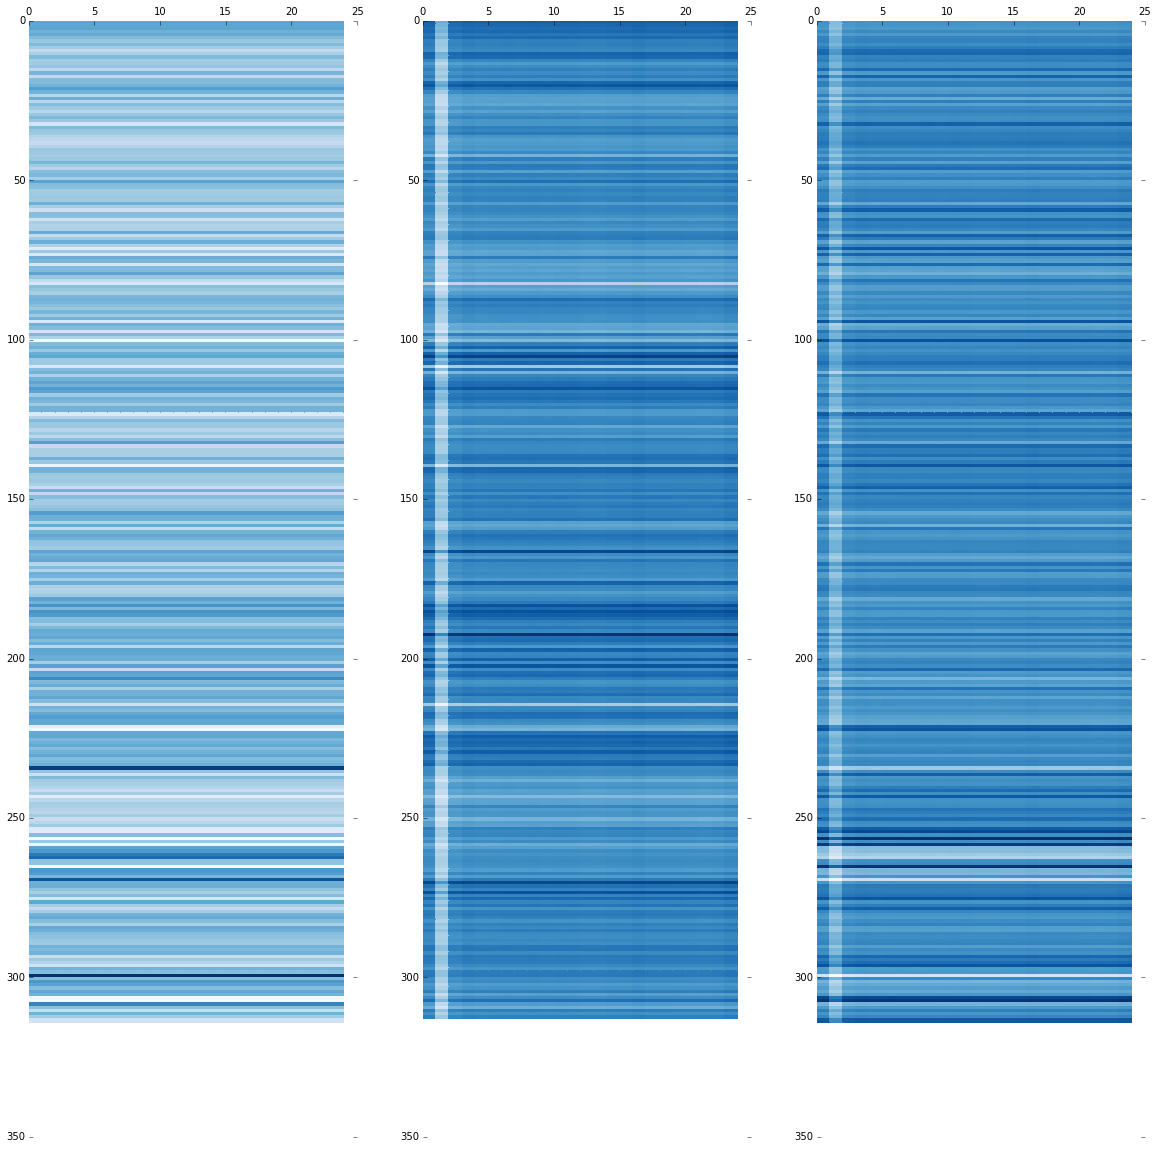

In [22]:
# make figure for heat map
fig, ax = plt.subplots(1,3)

# heat map of original business ages
heatmap = ax[0].pcolor(age_code_og,cmap=plt.cm.Blues)
# fix presentation
fig = plt.gcf()
fig.set_size_inches(20, 20)
# turn off the frame
ax[0].set_frame_on(False)
# want a more natural, table-like display
ax[0].invert_yaxis()
ax[0].xaxis.tick_top()
ax[0].grid(False)

# heat map of model output business ages for every tract/code combo
heatmap = ax[1].pcolor(df_map.values,cmap=plt.cm.Blues)
# turn off the frame
ax[1].set_frame_on(False)
# want a more natural, table-like display
ax[1].invert_yaxis()
ax[1].xaxis.tick_top()
ax[1].grid(False)

# heat map of relative diffs
heatmap = ax[2].pcolor(df_map_diff.values,cmap=plt.cm.Blues)
# turn off the frame
ax[2].set_frame_on(False)
# want a more natural, table-like display
ax[2].invert_yaxis()
ax[2].xaxis.tick_top()
ax[2].grid(False)

plt.show()

## Make a histogram and do some stats on the WhereSIOUS scores

64.5396539615
65.47442117
10.9273044169


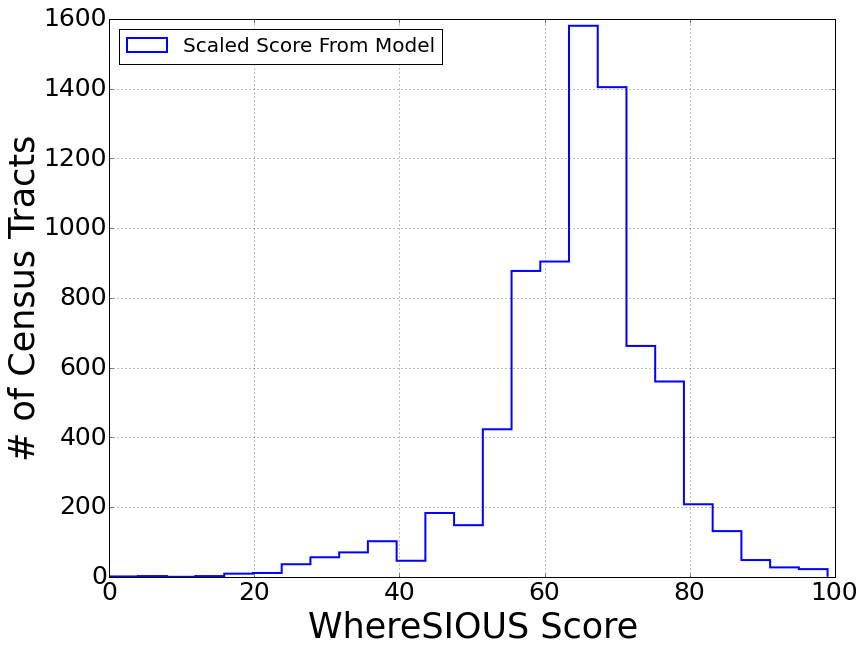

In [23]:
# make histogram of diffs scaled 0 to 100
plt.figure(figsize=(13, 10))
plt.hist(df_ages.score, bins=25, histtype='step', align='mid', linewidth=2, \
         label=['Scaled Score From Model'])
plt.legend(loc=2,fontsize=20)
plt.xlim(0,100)
plt.grid()
plt.tick_params(axis='both', which='major', labelsize=25)
plt.xlabel('WhereSIOUS Score',fontsize=35)
plt.ylabel('# of Census Tracts',fontsize=35)

# print some stats about model output
mean = np.mean(df_ages.score)
print mean
print np.median(df_ages.score)
std = np.std(df_ages.score)
print std

## Cut 3-sigma outliers maybe?

In [24]:
# shift 3-sigma outlier scores by hand
#print sum(df_scores.score<(mean-3*std))
#df_scores.score[df_scores.score<(mean-3*std)] = mean-3*std
#print sum(df_scores.score>(mean+3*std))
#df_scores.score[df_scores.score>(mean+3*std)] = mean+3*std

# make histogram of shifted diffs
#plt.figure(figsize=(13, 10))
#plt.hist(df_scores.score, bins=30, histtype='step', align='mid', linewidth=2, \
#         label=['Scaled Difference in Before and After Scores'])
#plt.legend(loc=0,fontsize=20)
#plt.grid()
#plt.tick_params(axis='both', which='major', labelsize=25)
#plt.xlabel('WhereSIOUS Score',fontsize=35)
#plt.ylabel('# of Census Tracts',fontsize=35)

# print some stats about model output
#print np.mean(df_scores.score)
#print np.median(df_scores.score)
#print np.std(df_scores.score)

In [25]:
# get max scores for each code
maxes = df_ages.groupby('code_simple').score.max()
# go through each code
for i in range(0,len(maxes)):
    print df_ages[(maxes.values[i]==df_ages.score.values) & (maxes.index[i]==df_ages.code_simple.values)]

print
print
# get max scores for each tract
maxes = df_ages.groupby('census_tract').score.max()
# go through each tract
for i in range(0,len(maxes)):
    print df_ages[(maxes.values[i]==df_ages.score.values) & (maxes.index[i]==df_ages.census_tract.values)]

     census_tract  code_simple     score
192        8511.0         11.0  97.65769
     census_tract  code_simple     score
506        8511.0         21.0  66.79195
     census_tract  code_simple      score
820        8511.0         22.0  94.891074
      census_tract  code_simple      score
1134        8511.0         23.0  97.369591
      census_tract  code_simple      score
1448        8511.0         31.0  96.547503
      census_tract  code_simple      score
1762        8511.0         32.0  96.885978
      census_tract  code_simple      score
2076        8511.0         33.0  97.040647
      census_tract  code_simple      score
2390        8511.0         42.0  96.969848
      census_tract  code_simple      score
2704        8511.0         44.0  97.263392
      census_tract  code_simple      score
3018        8511.0         45.0  97.052084
      census_tract  code_simple    score
3332        8511.0         48.0  97.2525
      census_tract  code_simple      score
3646        8511.0       

In [26]:
# get max scores for each code
maxes = df_ages.groupby('code_simple').score.min()
# go through each code
for i in range(0,len(maxes)):
    print df_ages[(maxes.values[i]==df_ages.score.values) & (maxes.index[i]==df_ages.code_simple.values)]

print
print
# get max scores for each tract
maxes = df_ages.groupby('census_tract').score.min()
# go through each tract
for i in range(0,len(maxes)):
    print df_ages[(maxes.values[i]==df_ages.score.values) & (maxes.index[i]==df_ages.census_tract.values)]

    census_tract  code_simple     score
82        3800.0         11.0  30.86622
     census_tract  code_simple  score
396        3800.0         21.0    0.0
     census_tract  code_simple      score
710        3800.0         22.0  28.099746
      census_tract  code_simple      score
1024        3800.0         23.0  30.577492
      census_tract  code_simple      score
1338        3800.0         31.0  29.756195
      census_tract  code_simple      score
1652        3800.0         32.0  30.094781
      census_tract  code_simple      score
1966        3800.0         33.0  30.249494
      census_tract  code_simple      score
2280        3800.0         42.0  30.178297
      census_tract  code_simple      score
2594        3800.0         44.0  30.471918
      census_tract  code_simple      score
2908        3800.0         45.0  30.260818
      census_tract  code_simple     score
3222        3800.0         48.0  30.46125
      census_tract  code_simple      score
3536        3800.0         49.0

In [27]:
# mean, median, stddev of each code
means = df_ages.groupby('code_simple').score.mean()
medians = df_ages.groupby('code_simple').score.median()
stds = df_ages.groupby('code_simple').score.std()
codes_list = stds.index
np.column_stack((codes_list,means,medians,stds))

array([[ 11.        ,  66.35589124,  66.23551284,   9.08317498],
       [ 21.        ,  35.48967184,  35.36928027,   9.083184  ],
       [ 22.        ,  63.58941721,  63.46903312,   9.08317412],
       [ 23.        ,  66.0671641 ,  65.94678475,   9.08318323],
       [ 31.        ,  65.24586626,  65.1254797 ,   9.08317435],
       [ 32.        ,  65.58445335,  65.46409061,   9.08317293],
       [ 33.        ,  65.73916403,  65.61877671,   9.08317172],
       [ 42.        ,  65.66797007,  65.54758604,   9.08317619],
       [ 44.        ,  65.96159144,  65.84121562,   9.08317531],
       [ 45.        ,  65.75049384,  65.63012841,   9.08317323],
       [ 48.        ,  65.95092018,  65.83054468,   9.08317329],
       [ 49.        ,  65.84934289,  65.72897502,   9.08317084],
       [ 51.        ,  65.28172906,  65.16133883,   9.08317161],
       [ 52.        ,  65.30826228,  65.18790556,   9.0831731 ],
       [ 53.        ,  65.82699289,  65.70661199,   9.08317632],
       [ 54.        ,  65

In [28]:
# mean, median, stddev of each code
means = df_ages.groupby('census_tract').score.mean()
medians = df_ages.groupby('census_tract').score.median()
stds = df_ages.groupby('census_tract').score.std()
codes_list = stds.index
stats_arr = np.column_stack((codes_list,means,medians,stds))
for i in range(0,len(codes_list)):
    print stats_arr[i]

[ 100.           79.58392471   80.87331428    6.22747131]
[ 201.           76.50748192   77.7968731     6.22746849]
[ 202.           74.11679016   75.40617388    6.22747558]
[ 300.           76.43676921   77.72614195    6.22746849]
[ 400.           70.62313028   71.91250444    6.22746822]
[ 500.           74.8531255    76.1425071     6.22747501]
[ 600.           67.26947297   68.55885918    6.22747535]
[ 700.           68.05892121   69.34831309    6.22746846]
[ 800.           65.77823026   67.06762498    6.22747501]
[ 900.           64.41927658   65.70866279    6.22747534]
[ 1000.            77.48631383    78.77570642     6.22747517]
[ 1100.            75.78937398    77.07875452     6.2274675 ]
[ 1200.            65.73989486    67.02928958     6.22747724]
[ 1300.            56.87086021    58.16024004     6.22746945]
[ 1400.            62.35762641    63.64700978     6.22747557]
[ 1500.            67.27001971    68.55940805     6.22747197]
[ 1600.            62.57864919    63.86803611   

## Test reading from tract/code/score file

In [29]:
# test reading in dataframe of tracts, codes, and scores
temp = pd.read_csv('data_final/tracts_codes_scores.csv',index_col=0)
print temp.shape
print temp[:10]
print temp[-10:]

# test looking up a score given a tract and code
tract = 9104
code = 21
# get correct row of dataframe
score_row = temp[(temp.census_tract==tract) & (temp.code_simple==code)].score
# get score itself
score = score_row.values[0]
# format score to one decimal place
result = round(score)
print result

(7512, 3)
   census_tract  code_simple      score
0         100.0         11.0  81.400162
1         201.0         11.0  78.323715
2         202.0         11.0  75.933024
3         300.0         11.0  78.252983
4         400.0         11.0  72.439346
5         500.0         11.0  76.669361
6         600.0         11.0  69.085709
7         700.0         11.0  69.875155
8         800.0         11.0  67.594467
9         900.0         11.0  66.235513
      census_tract  code_simple      score
7526       20404.0         92.0  63.231285
7527       20706.0         92.0  70.789594
7528       20707.0         92.0  57.290429
7529       20709.0         92.0  65.651634
7530       20710.0         92.0  76.805916
7531       21100.0         92.0  59.591717
7532       21302.0         92.0  51.328765
7533       21400.0         92.0  71.456394
7534       21500.0         92.0  63.478479
7535       21800.0         92.0  70.527453
47.0


## Try fitting using LASSO

In [30]:
tract = features.census_tract.values
feat = features.drop('census_tract', 1)

feat = feat.drop('population_percent_male',1)
feat = feat.drop('age_med_male',1)
feat = feat.drop('age_med_female',1)
feat = feat.drop('minor_percent',1)
feat = feat.drop('homes_percent_mortgage',1)
feat = feat.drop('homes_percent_clear',1)
feat = feat.drop('homes_percent_rent',1)

#feat = feat.drop('n_businesses_21',1)
#feat = feat.drop('n_businesses_22',1)
#feat = feat.drop('n_businesses_31',1)
#feat = feat.drop('n_businesses_49',1)
#feat = feat.drop('n_businesses_55',1)
#feat = feat.drop('n_businesses_92',1)
#feat = feat.drop('total_amount',1)

print tract
feat.values

[  100   201   202   300   400   500   600   700   800   900  1000  1100
  1200  1300  1400  1500  1600  1700  1800  1900  2001  2002  2100  2201
  2202  2301  2302  2401  2402  2501  2502  2601  2602  2702  2703  2705
  2707  2708  2709  2710  2711  2712  2801  2803  2804  2902  2903  2904
  2905  3001  3003  3004  3101  3103  3105  3107  3109  3111  3112  3113
  3114  3115  3201  3202  3208  3209  3211  3212  3213  3214  3301  3303
  3304  3305  3401  3403  3404  3501  3502  3601  3602  3603  3800  3901
  3902  4000  4100  4200  4300  4400  4501  4600  4700  4800  4900  5000
  5100  5200  5300  5400  5500  5600  5700  5800  5900  6000  6100  6200
  6300  6500  6600  6801  6802  6900  7002  7100  7200  7301  7302  7400
  7501  7502  7600  7701  7702  7800  7903  7905  7907  7908  7910  8002
  8003  8006  8101  8102  8200  8301  8303  8305  8306  8307  8310  8311
  8312  8313  8324  8327  8328  8329  8330  8331  8333  8335  8336  8337
  8339  8340  8341  8343  8344  8345  8346  8347  8

array([[  5.41876295e-01,   4.02439024e-02,   2.50000000e-01, ...,
          5.92592593e-01,   5.83333333e-01,   0.00000000e+00],
       [  5.38250962e-01,   5.51829268e-02,   0.00000000e+00, ...,
          5.92592593e-01,   5.83333333e-01,   2.17659537e-02],
       [  5.41876295e-01,   5.57926829e-02,   2.50000000e-01, ...,
          6.17283951e-01,   5.00000000e-01,   5.90469418e-02],
       ..., 
       [  4.81725363e-01,   1.90548780e-01,   7.50000000e-01, ...,
          5.43209877e-01,   7.14285714e-01,   3.82860055e-04],
       [  3.60905593e-01,   8.35365854e-02,   0.00000000e+00, ...,
          0.00000000e+00,   5.59523810e-01,   0.00000000e+00],
       [  2.05090263e-01,   1.34146341e-02,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00]])

In [31]:
from sklearn import linear_model
clf = linear_model.Lasso(alpha=1)
clf.fit(feat.values, tract)
print(clf.coef_)
print(feat.columns[clf.coef_==0])
print(feat.columns)
print(clf.intercept_)

[  2465.04514681      0.          -3691.094565     -579.43523952
   6684.75396978   7290.74058126   3899.10676092 -20853.34011438     -0.
  14651.94729187 -10557.04293385   1842.43317815 -23443.66750675
  19921.29376089   1654.34547676  -3904.06906689   5601.90226392
  13965.12122024    502.53765514 -25481.88020632     -0.          -2951.63135107
  -5996.34032462  17942.68583023     -0.             59.18454044
  11263.2876441     420.24896601   9458.23577357   -654.23496671
   -960.24203375  -2222.38829265  -8053.04209492  -1387.50784033
   -616.51529035   7720.51654042   -413.97356449   2045.97464171
 -17049.78653929  -2648.69153293  14520.06373187 -10035.08021213]
Index([u'n_business', u'n_businesses_33', u'n_businesses_61',
       u'n_businesses_81'],
      dtype='object')
Index([u'bus_age', u'n_business', u'n_businesses_11', u'n_businesses_21',
       u'n_businesses_22', u'n_businesses_23', u'n_businesses_31',
       u'n_businesses_32', u'n_businesses_33', u'n_businesses_42',
     

In [32]:
clf.score(feat.values, tract)

0.50921810511201393

## Try a random forest classifier (for feature selection)

In [38]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier()
forest.fit(feat.values, tract)
print(forest.feature_importances_)
print(feat.columns[forest.feature_importances_>0.3])
print(feat.columns)
print forest.score(feat.values, tract)

[ 0.04473812  0.02854326  0.01026359  0.00064015  0.00345138  0.0279157
  0.01329862  0.01269425  0.01943983  0.01680084  0.02191537  0.01900445
  0.03000857  0.01150179  0.02047612  0.01648854  0.01817713  0.02931484
  0.00934342  0.0293344   0.0215266   0.01784829  0.02911764  0.02275781
  0.02950935  0.00348404  0.03214888  0.02704482  0.04138298  0.04400923
  0.0383952   0.03556324  0.03653766  0.0345512   0.03721429  0.03056803
  0.02784101  0.0292726   0.02619316  0.01933959  0.02607189  0.00627212]
Index([], dtype='object')
Index([u'bus_age', u'n_business', u'n_businesses_11', u'n_businesses_21',
       u'n_businesses_22', u'n_businesses_23', u'n_businesses_31',
       u'n_businesses_32', u'n_businesses_33', u'n_businesses_42',
       u'n_businesses_44', u'n_businesses_45', u'n_businesses_48',
       u'n_businesses_49', u'n_businesses_51', u'n_businesses_52',
       u'n_businesses_53', u'n_businesses_54', u'n_businesses_55',
       u'n_businesses_56', u'n_businesses_61', u'n_bus

## Learning Curve

In [33]:
from sklearn import cross_validation
from sklearn.learning_curve import learning_curve

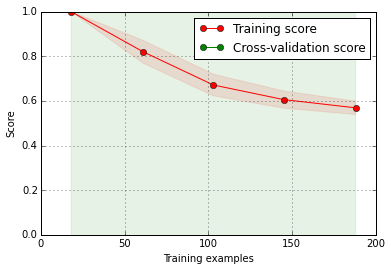

[ -2.74505436e+00  -6.78941455e+16  -2.77386217e+15  -1.95810655e+24
  -3.94099984e+14]


In [55]:
cv = cross_validation.ShuffleSplit(len(feat), n_iter=100, test_size=0.4)

estimator = linear_model.LinearRegression()

plt.figure()
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.ylim((0,1))
train_sizes, train_scores, test_scores = learning_curve(estimator, feat.values, tract, \
                                                        cv=cv, train_sizes=np.linspace(.1, 1.0, 5))
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1,\
                     color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, \
                 color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",label="Cross-validation score")
plt.legend(loc="best")
plt.show()
print test_scores_mean